# Likelihood ratios of mixtures of normals

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [2]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

Next we generate an artificial observed dataset `X_true`.

In [3]:
X_true = p0.rvs(5000, random_state=777)

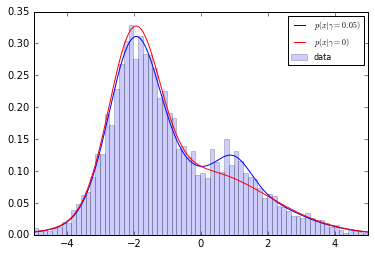

In [4]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\gamma=0.05)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\gamma=0)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
#plt.savefig("fig1a.pdf")
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, calibrating the resulting classifier, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios and calibrating each corresponding pair-wise classifier.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

n_samples = 200000
clf = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)  

# No calibration
cc_none = ClassifierRatio(base_estimator=clf, random_state=1)
cc_none.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Direct approximation 
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)
cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=15, cv=cv), 
    random_state=0)
cc_direct.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Decomposition of the mixture
cc_decomposed = DecomposedRatio(ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=20, cv=cv), 
    random_state=0))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=n_samples)

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:

- `base_estimator` specifying the classifier to be used (note commented `ExtraTreesRegressor`),
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.


Next we plot $\log r(x)$ vs. $x$ for the different cases.

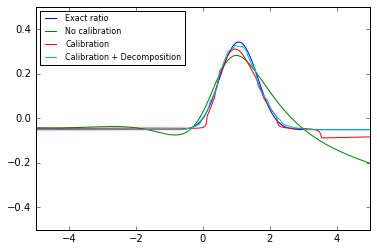

In [6]:
plt.plot(reals, -p0.nll(reals.reshape(-1, 1))  
                +p1.nll(reals.reshape(-1, 1)), label="Exact ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
#plt.savefig("fig1c.pdf")
plt.show()

Below is an alternative plot (that works in higher dimensions when the true likleihood is known) to check if the uncalibrated classifier is monotonically related to the true likelihood ratio.

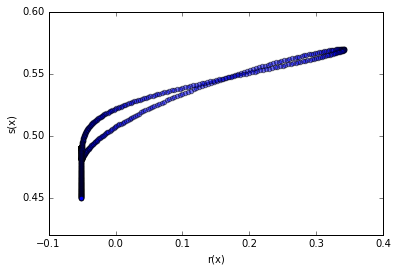

In [8]:
plt.scatter(-p0.nll(reals.reshape(-1, 1)) + p1.nll(reals.reshape(-1, 1)), 
            cc_none.classifier_.predict_proba(reals.reshape(-1, 1))[:, 0], alpha=0.5)
plt.xlabel("r(x)")
plt.ylabel("s(x)")
plt.show()

Now we inspect the distribution of the exact $\log {r}(x)$ and approximate $\log \hat{r}(x)$.

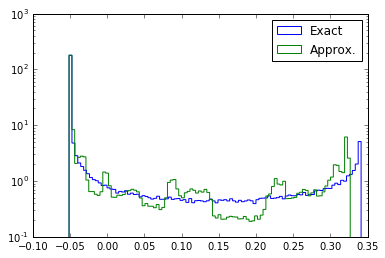

In [10]:
g.set_value(bump_coefficient)
X0 = p0.rvs(200000)
plt.hist(-p0.nll(X0) + p1.nll(X0), bins=100, histtype="step", label="Exact", normed=1)
plt.hist(cc_decomposed.predict(X0, log=True), bins=100,  histtype="step", label="Approx.", normed=1)
plt.yscale("log")
plt.legend()
#plt.savefig("fig1e.pdf")
plt.show()

## Using density ratios for maximum likelihood fit

Next let us construct the log-likelihood curve for the artificial dataset. 

In [11]:
def nll_true(theta, X):
    g.set_value(theta[0])
    return (p0.nll(X) - p1.nll(X)).sum()

def nll_approx(theta, X):
    g.set_value(theta[0])
    return -np.sum(cc_decomposed.predict(X, log=True))

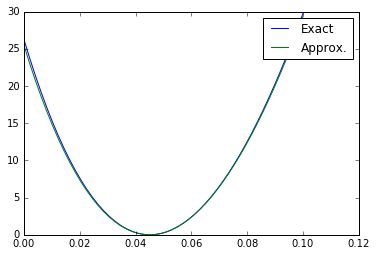

In [12]:
g_scan = np.linspace(0.0, 2 * bump_coefficient, 50)
nll_true_scan = np.array([nll_true([t], X_true) for t in g_scan])
nll_approx_scan = np.array([nll_approx([t], X_true) for t in g_scan])
plt.plot(g_scan, nll_true_scan-nll_true_scan.min(), label="Exact")
plt.plot(g_scan, nll_approx_scan-nll_approx_scan.min(), label="Approx.")
plt.legend()
#plt.savefig("fig1f.pdf")
plt.show()

A nice approximation of the exact likelihood. 

## Ensemble tests 

Now let us perform an ensemble test with 1000 repeated experiments. We will use this to check bias of the maximum likelihood estimator and the asymptotic distribution of $-2\log \Lambda(\gamma)$ (ie. Wilks's theorem).

In [13]:
from sklearn.utils import check_random_state
from scipy.optimize import minimize

n_trials = 1000

true_mles = []
true_nll = []
approx_mles = []
approx_nll = []

for i in range(n_trials):        
    # Generate new data
    g.set_value(bump_coefficient)
    X_true = p0.rvs(5000, random_state=i)
    
    # True MLE
    results = minimize(nll_true, x0=[0.1], args=(X_true,),
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    true_mles.append(results.x[0])
    true_nll.append(2. * (nll_true([bump_coefficient], X_true) - results.fun))
    
    # Inference with ratios
    results = minimize(nll_approx, x0=[0.1], args=(X_true,),
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    approx_mles.append(results.x[0])
    approx_nll.append(2. * (nll_approx([bump_coefficient], X_true) - results.fun))

In [14]:
true_mles = np.array(true_mles)
true_mles = true_mles[np.isfinite(true_mles)]
approx_mles = np.array(approx_mles)
approx_mles = approx_mles[np.isfinite(approx_mles)]
np.mean(true_mles), np.mean(approx_mles)

(0.050114731275088642, 0.050060529983498012)

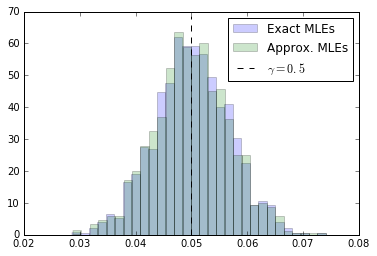

In [15]:
h = plt.hist(true_mles, bins=30, normed=1, alpha=0.2, color="b", label="Exact MLEs")
h = plt.hist(approx_mles, bins=30, normed=1, alpha=0.2, color="g", label="Approx. MLEs")
plt.vlines(bump_coefficient, 0, h[0].max()+5, linestyles="dashed", label=r"$\gamma = 0.5$")
plt.legend()
#plt.savefig("fig2a.pdf")
plt.show()

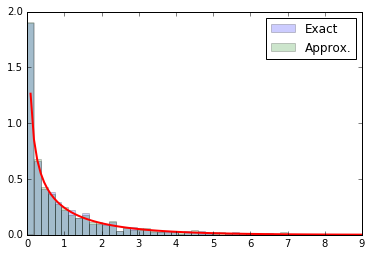

In [16]:
from scipy.stats import chi2

bins = np.linspace(0, 9, 50)
test = np.linspace(0, 9, 100)
true_counts, _, _ = plt.hist(2 * true_nll, bins=bins, normed=1, alpha=0.2, label="Exact")
approx_counts, _, _ = plt.hist(2 * approx_nll, bins=bins, normed=1, alpha=0.2, label="Approx.")
plt.plot(test, chi2.pdf(test, df=1), lw=2)
plt.legend()
#plt.savefig("fig2b.pdf")
plt.show()